In [1]:
%reset -f
!pyclean .

Cleaning directory .
Total 2 files, 1 directories removed.


In [2]:
from utils import *
%matplotlib inline

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
DATA_DIRECTORY

'D:\\spacecraft\\data'

In [5]:
metadata = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_metadata.csv"))

In [6]:
metadata.head(1)

,image_id,spacecraft_id,background_id
0,0001954c9f4a58f7ac05358b3cda8d20,24,247


In [7]:
bbox = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_labels.csv"), index_col="image_id")
image_list = [i.split(".")[0] for i in os.listdir(IMAGES_DIRECTORY)]
bbox = bbox[bbox.index.to_series().apply(lambda x: x in image_list)]

In [8]:
bbox.head(1)

,xmin,ymin,xmax,ymax
image_id,,,,
000dbf763348037b46558bbcb6a032ac,160,434,203,481


In [9]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.tolist()

def display_image(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=bbox):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir + f"//{image_id}.png"))
    fig, ax = plt.subplots()
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

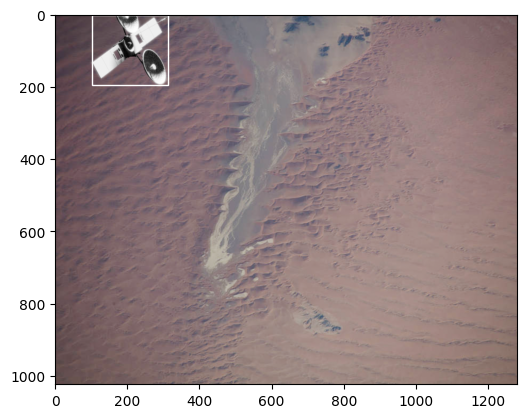

In [10]:
display_image("000f13aff94499d03e3997afc55b0aa0", show_bbox=True)

In [11]:
os.listdir(IMAGES_DIRECTORY)

['000dbf763348037b46558bbcb6a032ac.png',
 '000e79208bebd8e84ce6c22fd8612a0d.png',
 '000f13aff94499d03e3997afc55b0aa0.png',
 '00a2e221a62f5c98c116f977ee4a447d.png',
 '00a5abac1b2784e032c6c4d26db5d57f.png',
 '00a6e3e5280453302ddf5fe174fba37b.png',
 '00a9b9394502c46d499db834a7561ff7.png',
 '00a257cb17325152e35c0ccd17e3ad51.png']

In [12]:
train_paths = [IMAGES_DIRECTORY + "\\" +i for i in os.listdir(IMAGES_DIRECTORY)]
train_labels = [[row["xmin"], row["ymin"], row["xmax"], row["ymax"]] for _, row in bbox.iterrows()]

In [13]:
no_bg_meta = pd.read_csv(os.path.join(DATA_DIRECTORY,"no_background","no_background.csv"),index_col="image_id")
no_bg_meta.head(1)

,spacecraft_id,xmin,ymin,xmax,ymax
image_id,,,,,
23c7f89d00006caee536a22e5807de95,5,994,596,1079,705


In [14]:
spacecraft_5 = [os.path.join(DATA_DIRECTORY,"no_background", "images", i) + ".png" for i in no_bg_meta[no_bg_meta.spacecraft_id == 5].index]
spacecraft_5_bbox = [[k["xmin"], k["ymin"], k["xmax"], k["ymax"]] for i,k in no_bg_meta.iterrows()if k["spacecraft_id"] == 5]

In [15]:
len(spacecraft_5)

250

In [16]:
for i in spacecraft_5_bbox:
    print([i[0],i[1]])
    break

[994, 596]


In [17]:
space5 = dataset_flow(spacecraft_5, spacecraft_5_bbox, batch_size=2)
space5
image_sample, bbox_sample = next(space5.__iter__())

In [18]:
bbox_sample

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[173.95   , 130.375  , 188.825  , 154.21875],
       [135.625  , 171.28125, 149.625  , 194.03125]])>

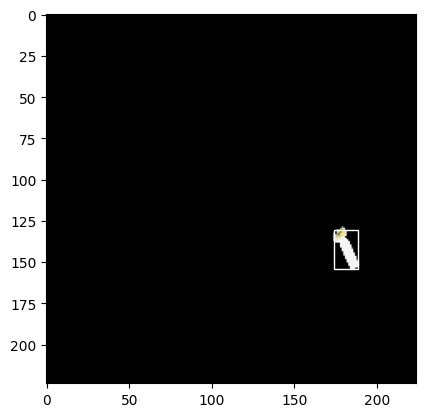

In [19]:
fig, ax = plt.subplots()
plt.imshow(image_sample.numpy()[0][:,:,:])
xmin, ymin, xmax, ymax =(i for i in bbox_sample.numpy()[0].flatten())
patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
ax.add_patch(patch)

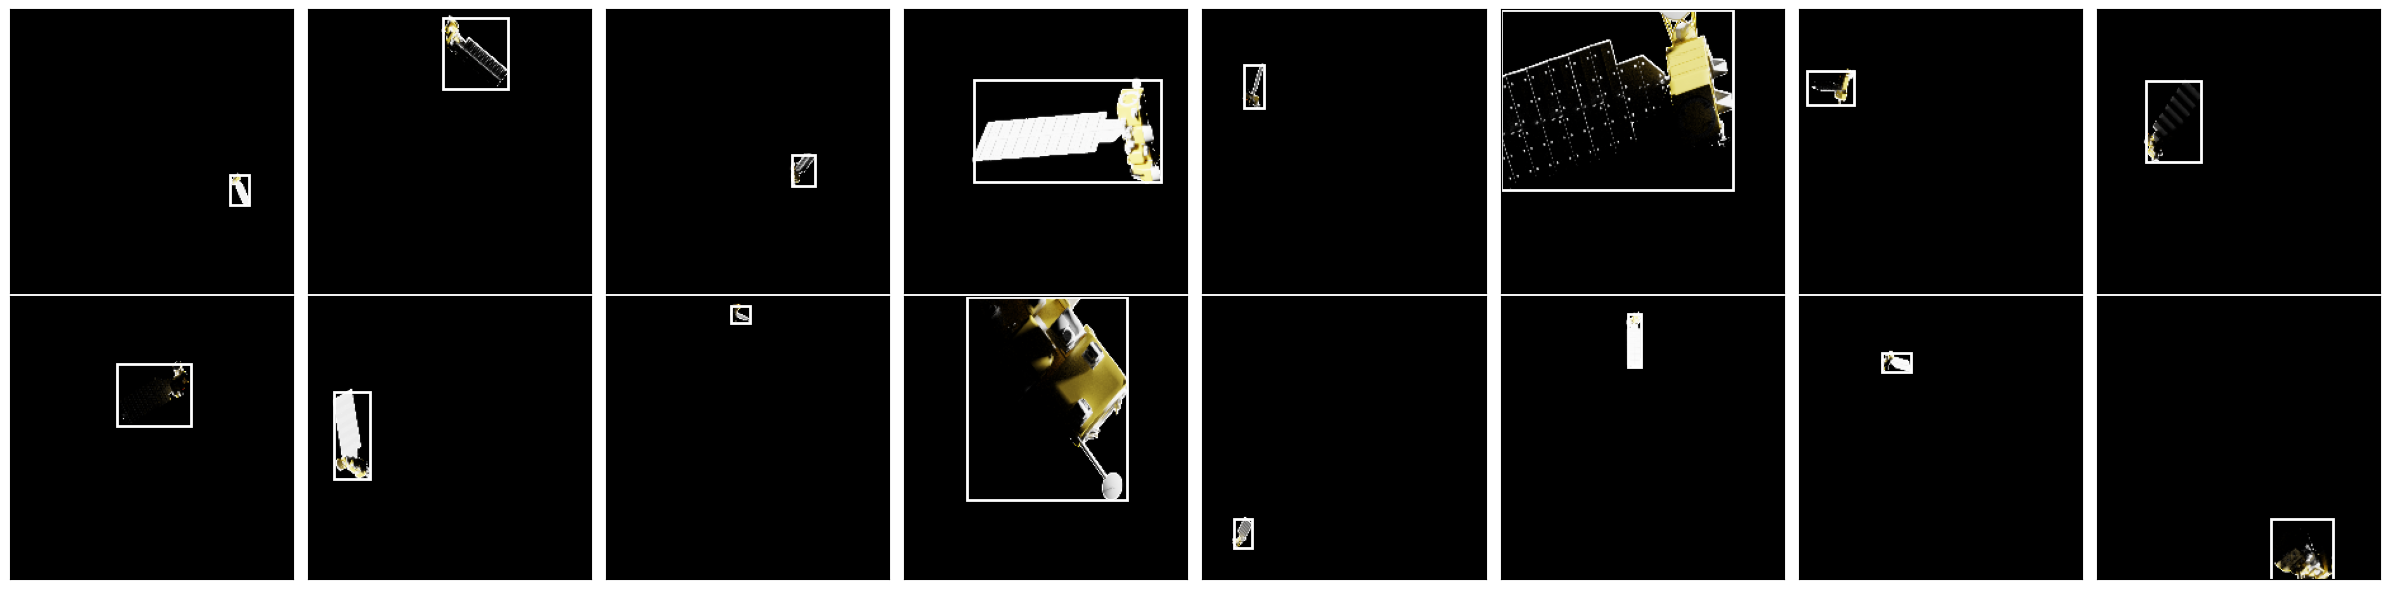

In [20]:
# Create a figure with a 2x8 grid of axes
fig, axes = plt.subplots(2, 8, figsize=(24, 6))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over the first 16 batches of the dataset
for ax, (image_sample, bbox_sample) in zip(axes_flat, space5.take(16)):
    # Display the image on the current axes
    ax.imshow(image_sample.numpy()[0])

    # Extract the bounding box coordinates and flatten them
    xmin, ymin, xmax, ymax = bbox_sample[0].numpy().flatten()

    # Create a Rectangle patch for the current bounding box
    patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=2)
    
    # Add the patch to the current axes
    ax.add_patch(patch)

    # Optional: Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
image_path = os.path.join(IMAGES_DIRECTORY, "00a5abac1b2784e032c6c4d26db5d57f.png")

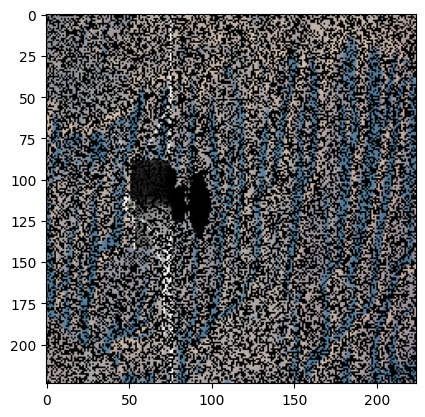

In [22]:
image_mask,_ = preprocess_image(image_path)
random_2d = np.random.randint(0, 2, size=(224, 224))
# Expand the 2D array to 3D by repeating the values across the last axis
random_3d = np.repeat(random_2d[:, :, np.newaxis], 3, axis=2)
plt.imshow(image_mask.numpy()*random_3d)

In [23]:
resnet101 = tf.keras.applications.ResNet101(include_top=True, weights='imagenet')


In [24]:
resnet101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [25]:
c2_output, c3_output, c4_output, c5_output = build_resnet_backbone(Input(shape=(224, 224, 3)))

In [26]:
c2_output

<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2_block3_out')>

In [27]:
c3_output

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv3_block4_out')>

In [28]:
# Create the model
model = resnet_fpn((224,224,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [29]:
fpn_feature_maps = model.predict(image_sample)

# Now, assume `integrate_rpn_with_fpn` correctly handles FPN outputs to produce RPN outputs
# Since `integrate_rpn_with_fpn` is conceptual, let's say you've structured it to accept real FPN outputs directly


1/1 [==============================] - 9s 9s/step


In [30]:
fpn_feature_maps

[array([[[[ 1.93110538e+00, -4.28734154e-01,  1.73431838e+00, ...,
            1.06439352e-01, -1.96175110e+00, -2.35970426e+00],
          [ 2.70449138e+00,  2.48783755e+00, -2.92282999e-01, ...,
           -1.10961187e+00,  2.18840575e+00, -5.57382965e+00],
          [ 2.82351780e+00,  2.46801066e+00,  2.75243849e-01, ...,
           -1.28978240e+00,  2.35625529e+00, -4.83889103e+00],
          ...,
          [ 1.84147465e+00,  2.42024112e+00, -7.55768681e+00, ...,
           -4.95465565e+00,  1.34903502e+00, -1.00635080e+01],
          [ 2.07788396e+00,  2.90282416e+00, -7.94365168e+00, ...,
           -5.20445013e+00,  5.43347538e-01, -1.05604448e+01],
          [ 2.77891207e+00,  5.17182732e+00, -8.15163994e+00, ...,
           -4.70326281e+00,  1.81503785e+00, -7.31722260e+00]],
 
         [[ 4.43957567e+00, -3.65039778e+00,  4.82122749e-01, ...,
           -4.15800214e-01,  1.95485377e+00, -2.63650626e-01],
          [ 3.98345399e+00, -3.36642814e+00, -2.10474396e+00, ...,
     

In [31]:
for i in fpn_feature_maps:
    print(i.shape)

(2, 56, 56, 256)
(2, 28, 28, 256)
(2, 14, 14, 256)
(2, 7, 7, 256)
(2, 4, 4, 256)


## 4 layers in and 5 layers out
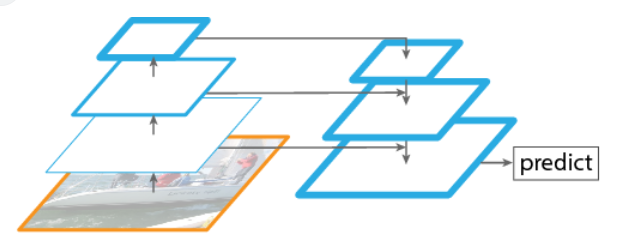

# No Problem Until here

# Finish the creation of the Featured Pyramaid Network

In [32]:
def rpn_layer(feature_maps, anchors_size=9):
    """
    Creates a Region Proposal Network that takes feature maps from the FPN as input and returns
    objectness score and bounding box regressions for each anchor.
    Args:
    - feature_maps: List of feature maps from different levels of the FPN.
    - anchors_size: Number of anchors at each location.
    Returns:
    - rpn_class_logits: Objectness scores for each anchor.
    - rpn_probs: Softmax probabilities for objectness scores.
    - rpn_bbox: Bounding box regressions for each anchor.
    """
    rpn_class_logits = []
    rpn_probs = []
    rpn_bbox = []

    for fmap in feature_maps:
        # Objectness score
        scores = Conv2D(2 * anchors_size, (1, 1), padding='same', activation='linear', name='rpn_class_raw')(fmap)
        logits = Reshape([-1, 2])(scores)
        probs = tf.nn.softmax(logits)

        # Bounding box regression
        bboxes = Conv2D(4 * anchors_size, (1, 1), padding='same', activation='linear', name='rpn_bbox_pred')(fmap)
        bboxes = Reshape([-1, 4])(bboxes)

        rpn_class_logits.append(logits)
        rpn_probs.append(probs)
        rpn_bbox.append(bboxes)

    return rpn_class_logits, rpn_probs, rpn_bbox

In [33]:
# Generate RPN layers
rpn_class_logits, rpn_probs, rpn_bbox = rpn_layer(fpn_feature_maps)

# Next steps would involve selecting the top proposals based on objectness scores,
# applying NMS, and then using these proposals for RoI Pooling.

In [34]:
rpn_class_logits

[<tf.Tensor: shape=(2, 28224, 2), dtype=float32, numpy=
 array([[[ 3.4345233 , -1.6036618 ],
         [ 4.825591  ,  2.1783247 ],
         [-1.5998771 , -0.44529176],
         ...,
         [-1.7157624 , -1.140316  ],
         [ 1.8153379 , -2.430183  ],
         [ 2.2318993 ,  5.118709  ]],
 
        [[ 3.4360323 , -1.6041062 ],
         [ 4.8264127 ,  2.1776798 ],
         [-1.5989432 , -0.4459722 ],
         ...,
         [-1.916898  , -1.3066195 ],
         [ 1.8253388 , -1.9094598 ],
         [ 2.0844169 ,  5.52989   ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 7056, 2), dtype=float32, numpy=
 array([[[ 4.9787393 , -3.933537  ],
         [ 0.5622865 , -7.764184  ],
         [ 1.215467  ,  0.64193875],
         ...,
         [-3.877002  ,  2.2386293 ],
         [ 7.465914  ,  6.535752  ],
         [ 4.9030056 , -7.29227   ]],
 
        [[ 4.98052   , -3.936019  ],
         [ 0.56273496, -7.76638   ],
         [ 1.2139354 ,  0.64345497],
         ...,
         [-4.4865217 ,  2.01926

In [35]:
rpn_probs

[<tf.Tensor: shape=(2, 28224, 2), dtype=float32, numpy=
 array([[[0.9935563 , 0.00644372],
         [0.93384224, 0.06615769],
         [0.23965254, 0.7603475 ],
         ...,
         [0.35998106, 0.64001894],
         [0.9858742 , 0.01412587],
         [0.05280947, 0.9471905 ]],
 
        [[0.9935688 , 0.00643123],
         [0.93393284, 0.06606714],
         [0.23994683, 0.76005316],
         ...,
         [0.3519957 , 0.64800435],
         [0.9766789 , 0.02332112],
         [0.03090415, 0.9690958 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 7056, 2), dtype=float32, numpy=
 array([[[9.9986529e-01, 1.3470666e-04],
         [9.9975806e-01, 2.4196622e-04],
         [6.3957691e-01, 3.6042312e-01],
         ...,
         [2.2032168e-03, 9.9779677e-01],
         [7.1710819e-01, 2.8289187e-01],
         [9.9999499e-01, 5.0542490e-06]],
 
        [[9.9986589e-01, 1.3413385e-04],
         [9.9975866e-01, 2.4132735e-04],
         [6.3887405e-01, 3.6112598e-01],
         ...,
         [1.4925274

In [36]:

rpn_bbox

[<tf.Tensor: shape=(2, 28224, 4), dtype=float32, numpy=
 array([[[ -0.79335386,  -1.460846  ,  -2.2672038 ,  -1.0564164 ],
         [  0.36469275,  -2.845236  ,  -2.0716739 ,  -0.8967433 ],
         [ -1.2130407 ,   1.3732033 ,   4.449627  ,   1.4573085 ],
         ...,
         [  5.846273  , -10.138015  ,  -2.8739893 ,   2.805548  ],
         [  3.7419605 ,   0.19099292,   1.9637225 ,   0.07526392],
         [  4.2836084 ,  -0.65437317,  -4.0277934 ,  -3.320904  ]],
 
        [[ -0.7910598 ,  -1.4606942 ,  -2.2683153 ,  -1.055598  ],
         [  0.36814296,  -2.844876  ,  -2.072962  ,  -0.8951624 ],
         [ -1.2131927 ,   1.3749353 ,   4.4525146 ,   1.4575405 ],
         ...,
         [  5.892146  , -10.159707  ,  -3.0514839 ,   2.8976643 ],
         [  2.9872754 ,   0.34400803,   1.9023334 ,   0.2167071 ],
         [  3.8628206 ,  -0.72224766,  -3.4480836 ,  -3.5003784 ]]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 7056, 4), dtype=float32, numpy=
 array([[[ 3.2308853 , -4.84

In [37]:
def bbox_transform_inv(anchors, deltas):
    """
    Applies the bounding box transformation deltas to the anchors.

    Args:
    - anchors: Tensor of shape (N, 4) representing anchor boxes.
        Each row is [y1, x1, y2, x2].
    - deltas: Tensor of shape (N, 4) representing predicted deltas.
        Each row is [dy, dx, dh, dw].

    Returns:
    - proposals: Tensor of shape (N, 4) representing the adjusted boxes.
        Each row is [y1, x1, y2, x2].
    """
    anchors_width = anchors[:, 3] - anchors[:, 1]
    anchors_height = anchors[:, 2] - anchors[:, 0]
    anchors_center_x = anchors[:, 1] + 0.5 * anchors_width
    anchors_center_y = anchors[:, 0] + 0.5 * anchors_height

    dx = deltas[:, 1]
    dy = deltas[:, 0]
    dw = deltas[:, 3]
    dh = deltas[:, 2]

    center_x = dx * anchors_width + anchors_center_x
    center_y = dy * anchors_height + anchors_center_y
    width = tf.exp(dw) * anchors_width
    height = tf.exp(dh) * anchors_height

    new_x1 = center_x - 0.5 * width
    new_y1 = center_y - 0.5 * height
    new_x2 = center_x + 0.5 * width
    new_y2 = center_y + 0.5 * height

    proposals = tf.stack([new_y1, new_x1, new_y2, new_x2], axis=1)
    return proposals

def apply_nms(proposals, scores, max_output_size, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression (NMS) to reduce the number of overlapping boxes.

    Args:
    - proposals: Tensor of shape (num_proposals, 4), each row is [y1, x1, y2, x2].
    - scores: Tensor of shape (num_proposals,) containing the scores for each proposal.
    - max_output_size: Maximum number of proposals to keep after NMS.
    - iou_threshold: Intersection Over Union (IOU) threshold for NMS filtering.

    Returns:
    - nms_indices: The indices of the proposals kept after NMS.
    """
    nms_indices = tf.image.non_max_suppression(
        proposals, scores, max_output_size=max_output_size, iou_threshold=iou_threshold)
    
    return nms_indices

def select_top_proposals(rpn_probs, rpn_bbox, anchors, num_rois=2000, pre_nms_limit=6000):
    """
    Selects the top proposals based on objectness scores and applies NMS.

    Args:
    - rpn_probs: Softmax probabilities for objectness scores from the RPN.
    - rpn_bbox: Bounding box regressions from the RPN.
    - anchors: The anchors corresponding to the RPN predictions.
    - num_rois: Number of RoIs to keep after NMS.
    - pre_nms_limit: Number of top scoring proposals to keep before applying NMS.

    Returns:
    - selected_proposals: The final proposals after selection and NMS.
    - selected_scores: Scores of the final proposals.
    """
    # Concatenate predictions across all feature maps
    rpn_probs_concat = tf.concat(rpn_probs, axis=1)
    rpn_bbox_concat = tf.concat(rpn_bbox, axis=1)

    # Select top proposals before NMS
    scores = rpn_probs_concat[:, 1]  # Use objectness score
    top_indices = tf.nn.top_k(scores, k=tf.minimum(pre_nms_limit, tf.shape(scores)[0])).indices
    top_scores = tf.gather(scores, top_indices)
    top_proposals = tf.gather(rpn_bbox_concat, top_indices)
    top_anchors = tf.gather(anchors, top_indices)

    # Apply bounding box regression to anchors
    proposals = bbox_transform_inv(top_anchors, top_proposals)

    # Apply NMS
    nms_indices = apply_nms(proposals, top_scores, max_output_size=num_rois)

    # Select final proposals and scores
    selected_proposals = tf.gather(proposals, nms_indices)
    selected_scores = tf.gather(top_scores, nms_indices)

    return selected_proposals, selected_scores

# Dummy anchors for demonstration purposes

# Assuming rpn_probs and rpn_bbox are obtained from the RPN layer
selected_proposals, selected_scores = select_top_proposals(rpn_probs, rpn_bbox, anchors)


NameError: name 'anchors' is not defined

In [ ]:
shit

In [ ]:
def generate_anchors_per_level(base_size, ratios, scales, feature_size, stride):
    """
    Generate anchors for one level of the FPN based on the feature map size, scales, and aspect ratios.
    Args:
        base_size (int): The base size of the anchors.
        ratios (list of float): Aspect ratios for the anchors.
        scales (list of float): Different scales for the anchors.
        feature_size (int): The size (height/width) of the feature map.
        stride (int): The stride of the feature map relative to the original image size.
    Returns:
        np.ndarray: An array of shape [num_anchors, 4] with anchor boxes in (x1, y1, x2, y2) format.
    """
    anchors = []
    for scale in scales:
        for ratio in ratios:
            # Calculate anchor dimensions based on scale and ratio
            anchor_height = base_size * scale * np.sqrt(ratio)
            anchor_width = base_size * scale / np.sqrt(ratio)
            
            for x in range(feature_size):
                center_x = (x + 0.5) * stride
                for y in range(feature_size):
                    center_y = (y + 0.5) * stride
                    anchors.append([
                        center_x - anchor_width / 2,
                        center_y - anchor_height / 2,
                        center_x + anchor_width / 2,
                        center_y + anchor_height / 2,
                    ])
    return np.array(anchors)

In [ ]:
anchors_list = []  # A list to hold anchors for all FPN levels
for feature_map in fpn_feature_maps:  # Assuming fpn_outputs is a list of your FPN feature maps
    width, height = feature_map.shape[1], feature_map.shape[2]  # Get width and height of the feature map
    anchors = generate_anchors_per_level(base_size=16, ratios=[0.5, 1, 2], scales=[2, 4, 8], feature_size=height, stride=calculate_stride(original_image_size, feature_map.shape))
    anchors_list.append(anchors)

In [ ]:
scales = [2 ** (scale / 3) for scale in range(3)]  # Example scales: [1, sqrt(2), 2]
ratios = [0.5, 1, 2]  # Common aspect ratios
strides = [4, 8, 16, 32, 64]  # Example strides for each FPN level
base_size = 16  # Starting base size for anchors

# Feature sizes corresponding to your FPN levels
feature_sizes = [56, 28, 14, 7, 4]

# Generate anchors for each FPN level
all_anchors = [generate_anchors_per_level(base_size=base_size, ratios=ratios, scales=scales, 
                                          feature_size=fs, stride=s) 
               for fs, s in zip(feature_sizes, strides)]


In [ ]:
all_anchors[2].shape

(1764, 4)

In [ ]:
fpn_feature_maps

[array([[[[-1.9448373 , -0.5817475 , -1.6916351 , ...,  2.276535  ,
           -2.65572   ,  0.10438683],
          [-2.1883724 ,  0.7275507 , -0.89919275, ...,  1.2588451 ,
            0.32973948,  0.7451836 ],
          [-2.111434  ,  1.1137598 , -1.6364251 , ...,  1.095671  ,
            0.7525075 ,  1.6654963 ],
          ...,
          [-6.6461535 ,  3.220039  , -2.6312616 , ...,  2.406994  ,
            2.9283018 ,  5.7299905 ],
          [-6.0591607 ,  2.7099812 , -0.34627065, ...,  2.1512656 ,
            3.1779292 ,  5.400722  ],
          [-6.7332735 ,  0.85005456, -0.3184754 , ..., -0.5048893 ,
            1.7744539 ,  6.0702314 ]],
 
         [[-0.7559253 ,  3.5963552 , -0.3877616 , ...,  0.44624725,
           -4.261549  , -0.7678948 ],
          [-0.7116035 ,  2.9527352 ,  0.01836644, ..., -1.7527648 ,
           -0.07796504, -1.0062033 ],
          [-0.41280174,  2.2653496 , -0.29458323, ..., -2.160002  ,
            0.8998247 , -0.05234621],
          ...,
          [-4

In [ ]:
def decode_deltas(deltas, anchors):
    """
    Args:
    deltas: Numpy array of shape (N, 4) containing deltas for the adjustments.
    anchors: Numpy array of shape (N, 4) containing anchor boxes in (x1, y1, x2, y2) format.
    
    Returns:
    proposals: Adjusted bounding boxes in (x1, y1, x2, y2) format.
    """
    widths = anchors[:, 2] - anchors[:, 0] + 1.0
    heights = anchors[:, 3] - anchors[:, 1] + 1.0
    ctr_x = anchors[:, 0] + 0.5 * widths
    ctr_y = anchors[:, 1] + 0.5 * heights

    dx = deltas[:, 0]
    dy = deltas[:, 1]
    dw = deltas[:, 2]
    dh = deltas[:, 3]   

    # Apply deltas
    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = np.exp(dw) * widths
    pred_h = np.exp(dh) * heights

    pred_boxes = np.zeros(deltas.shape)
    pred_boxes[:, 0] = pred_ctr_x - 0.5 * pred_w
    pred_boxes[:, 1] = pred_ctr_y - 0.5 * pred_h
    pred_boxes[:, 2] = pred_ctr_x + 0.5 * pred_w
    pred_boxes[:, 3] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes


In [ ]:
proposals = decode_deltas(rpn_bbox_deltas, all_anchors)


NameError: name 'rpn_bbox_deltas' is not defined

In [ ]:
ratios = [0.5, 1, 2]
scales = [2 ** x for x in range(3)]  # Example: scales relative to each FPN level

# Anchor strides for each FPN level, determined by the downscale factor of each FPN feature map
strides = [4, 8, 16, 32, 64]  # Example strides for each FPN level

feature_sizes = [(56, 56), (28, 28), (14, 14), (7, 7), (4, 4)]
anchors_list = []

def generate_anchors(base_size, ratios, scales, feature_size, stride):
    """
    Generate anchors for one level of the FPN.
    
    Args:
    - base_size: The size (width and height) of the base anchor.
    - ratios: List of aspect ratios for the anchors.
    - scales: List of scales to apply to the base anchor size.
    - feature_size: The spatial size (width, height) of the feature map.
    - stride: The stride of the feature map relative to the original image.
    
    Returns:
    - anchors: An array of shape (N, 4), where N is the number of anchors,
                and each anchor is defined by (x1, y1, x2, y2).
    """
    anchors = []
    for scale in scales:
        for ratio in ratios:
            # Calculate anchor dimensions based on scale and ratio
            anchor_height = base_size * scale * np.sqrt(ratio)
            anchor_width = base_size * scale / np.sqrt(ratio)
            
            # Generate anchors across the feature map
            for x in range(feature_size):
                center_x = (x + 0.5) * stride
                for y in range(feature_size):
                    center_y = (y + 0.5) * stride
                    anchors.append([
                        center_x - anchor_width / 2,
                        center_y - anchor_height / 2,
                        center_x + anchor_width / 2,
                        center_y + anchor_height / 2,
                    ])
    return np.array(anchors)

for feature_size, stride in zip(feature_sizes, strides):
    # Assuming a base size that's adjusted based on the stride
    base_size = stride * 2  # Example adjustment
    print(base_size)
    level_anchors = generate_anchors(base_size, ratios, scales, feature_size[0], stride)
    anchors_list.append(level_anchors)


8
16
32
64
128


In [ ]:
len(anchors_list)

5

In [ ]:
for i in range(5):
    print(anchors_list[i].shape)

(28224, 4)
(7056, 4)
(1764, 4)
(441, 4)
(144, 4)


In [ ]:
# Concatenate all anchors
all_anchors = np.concatenate(anchors_list, axis=0)

In [ ]:
def integrate_rpn_with_fpn(fpn_outputs):
    """
    Apply the RPN head to each FPN output level and concatenate the results.
    This is a conceptual demonstration; actual implementation may require adjustments.
    """
    rpn_class_logits_list = []
    rpn_bbox_deltas_list = []
    # Assuming 2 anchors per location for simplicity
    anchors_per_location = 9

    for feature_map in fpn_outputs:
        objectness_logits, bbox_deltas = build_rpn_head(feature_map, anchors_per_location)
        print(objectness_logits.shape)
        print(bbox_deltas.shape)
        # Flatten for easy concatenation
        rpn_class_logits_list.append(tf.reshape(objectness_logits, [tf.shape(objectness_logits)[0], -1]))
        rpn_bbox_deltas_list.append(tf.reshape(bbox_deltas, [tf.shape(bbox_deltas)[0], -1]))
        print(rpn_class_logits_list[0].shape)
        print(len(rpn_class_logits_list))
        print(rpn_bbox_deltas_list[0].shape)

    
    # Concatenate predictions from all levels
    rpn_class_logits_concat = Concatenate(axis=1)(rpn_class_logits_list)
    rpn_bbox_deltas_concat = Concatenate(axis=1)(rpn_bbox_deltas_list)

    return rpn_class_logits_concat, rpn_bbox_deltas_concat

In [ ]:
rpn_class_logits_concat, rpn_bbox_deltas_concat = integrate_rpn_with_fpn(fpn_feature_maps)

(2, 56, 56, 9)
(2, 56, 56, 36)
(2, 28224)
1
(2, 112896)
(2, 28, 28, 9)
(2, 28, 28, 36)
(2, 28224)
2
(2, 112896)
(2, 14, 14, 9)
(2, 14, 14, 36)
(2, 28224)
3
(2, 112896)
(2, 7, 7, 9)
(2, 7, 7, 36)
(2, 28224)
4
(2, 112896)
(2, 4, 4, 9)
(2, 4, 4, 36)
(2, 28224)
5
(2, 112896)


In [ ]:
rpn_class_logits_concat.shape

TensorShape([2, 37629])

In [ ]:
rpn_bbox_deltas_concat.shape

TensorShape([2, 150516])

In [ ]:
# Ensure rpn_bbox_deltas_concat has the shape [num_anchors, 4] and contains deltas for all anchors
# This might involve reshaping or processing the RPN output to match the anchor shapes
# Decode the deltas to get proposed boxes
proposed_boxes = decode_deltas(rpn_bbox_deltas_concat, all_anchors)


NameError: name 'rpn_bbox_deltas_concat' is not defined

In [ ]:
proposed_boxes

<tf.Tensor: shape=(37629, 4), dtype=float32, numpy=
array([[-2.5525681e+01, -2.1158705e+00,  4.5041451e+01, -9.5845896e-01],
       [-2.5525681e+01,  1.8841295e+00,  4.5041451e+01,  3.0415411e+00],
       [-2.5525681e+01,  5.8841295e+00,  4.5041451e+01,  7.0415411e+00],
       ...,
       [-6.5682178e+02, -4.3083142e+02,  1.6013264e+03, -2.8268274e+02],
       [-6.5682178e+02, -3.6683142e+02,  1.6013264e+03, -2.1868274e+02],
       [-6.5682178e+02, -3.0283142e+02,  1.6013264e+03, -1.5468274e+02]],
      dtype=float32)>

In [ ]:
rpn_class_logits, rpn_bbox_deltas = integrate_rpn_with_fpn(fpn_feature_maps)

In [ ]:

def apply_nms(proposals, scores, max_output_size=100, iou_threshold=0.7, score_threshold=float('-inf')):
    """
    Applies Non-Maximum Suppression (NMS) to filter out overlapping bounding boxes.

    Args:
    - proposals: Tensor of proposed bounding boxes, shape [num_boxes, 4].
    - scores: Tensor of scores for each proposal, shape [num_boxes].
    - max_output_size: Maximum number of boxes to keep.
    - iou_threshold: IoU threshold to use for filtering.
    - score_threshold: Minimum score threshold for a box to be considered.

    Returns:
    - nms_indices: The indices of the proposals kept after NMS.
    """
    # Apply NMS
    selected_indices = tf.image.non_max_suppression(
        proposals, scores, max_output_size, iou_threshold, score_threshold)
    
    return selected_indices


In [ ]:
# Assuming 'proposed_boxes' are the bounding boxes and 'rpn_class_logits' are the logits or scores from the RPN
# Convert logits to scores if necessary
scores = tf.nn.softmax(rpn_class_logits)[:, 1]  # Assuming binary classification (object vs. no object)

selected_indices = apply_nms(proposed_boxes, scores=scores, max_output_size=100, iou_threshold=0.7)

# Gather the final proposals using the selected indices from NMS
final_proposals = tf.gather(proposed_boxes, selected_indices)


InvalidArgumentError: {{function_node __wrapped__NonMaxSuppressionV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} scores has incompatible shape (Dimensions must be equal, but are 37629 and 1)
	 [[{{node NonMaxSuppressionV3}}]] [Op:NonMaxSuppressionV3]

In [ ]:

selected_indices = apply_nms(proposed_boxes, scores=rpn_class_logits, iou_threshold=0.7)
final_proposals = proposed_boxes[selected_indices]


InvalidArgumentError: {{function_node __wrapped__NonMaxSuppressionV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} scores must be a vector! (Shape must be rank 1 but is rank 2)
	 [[{{node NonMaxSuppressionV3}}]] [Op:NonMaxSuppressionV3]

In [ ]:
pooled_features = roi_align(features=fpn_outputs, proposals=final_proposals, pooled_height=7, pooled_width=7, spatial_scale=1.0/16)


NameError: name 'final_proposals' is not defined

In [ ]:
rpn_class_logits, rpn_bbox_deltas = integrate_rpn_with_fpn(fpn_feature_maps)

In [ ]:
28224 + 7056 + 1764 + 441 + 144

37629

In [ ]:
rpn_class_logits

<tf.Tensor: shape=(1, 37629), dtype=float32, numpy=
array([[0.6328891 , 0.375808  , 0.38902822, ..., 0.45688033, 0.43501353,
        0.26222253]], dtype=float32)>

In [ ]:
len(fpn_feature_maps)

5

In [ ]:
for i in range(5):
    print(fpn_feature_maps[i].shape)

(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 14, 14, 256)
(1, 7, 7, 256)
(1, 4, 4, 256)


In [ ]:
base_size = 16  # Starting point for the highest resolution map
ratios = [0.5, 1, 2]
scales = [2 ** 0, 2 ** (1.0 / 3), 2 ** (2.0 / 3)]

# Assuming a stride of 16 for an example feature map level
feature_size = 224 // 16  # Size of the feature map
stride = 16  # Downsample factor for the feature map

anchors = generate_anchors(base_size, ratios, scales, feature_size, stride)


In [ ]:
3 * 3 * 14 * 14

1764

In [ ]:
anchors.shape

(1764, 4)

In [ ]:
anchors

array([[ -3.3137085 ,   2.34314575,  19.3137085 ,  13.65685425],
       [ -3.3137085 ,  18.34314575,  19.3137085 ,  29.65685425],
       [ -3.3137085 ,  34.34314575,  19.3137085 ,  45.65685425],
       ...,
       [207.02030361, 166.04060723, 224.97969639, 201.95939277],
       [207.02030361, 182.04060723, 224.97969639, 217.95939277],
       [207.02030361, 198.04060723, 224.97969639, 233.95939277]])

In [ ]:
# Example: Using generated anchors and RPN predicted deltas
# Ensure anchors and rpn_bbox_deltas_concat are correctly shaped
# anchors: [num_anchors, 4], rpn_bbox_deltas_concat: [num_anchors, 4]

# Convert deltas from a tensor to a NumPy array if working with TensorFlow
if isinstance(rpn_bbox_deltas, tf.Tensor):
    rpn_bbox_deltas_concat_np = rpn_bbox_deltas.numpy()
else:
    rpn_bbox_deltas_concat_np = rpn_bbox_deltas

# Decode deltas to get proposed boxes
proposed_boxes = decode_deltas(rpn_bbox_deltas_concat_np, anchors)


ValueError: could not broadcast input array from shape (1764,) into shape (1,)

In [ ]:
def apply_nms(proposals, scores, max_output_size=1000, iou_threshold=0.5):
    indices = tf.image.non_max_suppression(
        proposals, scores, max_output_size=max_output_size, iou_threshold=iou_threshold)
    nms_proposals = tf.gather(proposals, indices)
    return nms_proposals



In [ ]:
# Assuming scales, ratios, and an example feature map size (feature_size) and stride
scales = [128, 256, 512]
ratios = [0.5, 1, 2]
feature_size = 56  # For a feature map size resulting from an input of 224x224
stride = 16  # Example stride for one of the FPN levels

# Generate anchors for one level of the FPN as an example
anchors = generate_anchors(base_size=16, ratios=ratios, scales=scales, feature_size=feature_size, stride=stride)


In [ ]:
# This requires defining your model architecture first
model = resnet_fpn(input_shape=(224, 224, 3))

# Get FPN outputs for an input image (placeholder `input_image`)
fpn_outputs = model(image_sample)

# Apply RPN head to each FPN output level and concatenate the results
rpn_class_logits_concat, rpn_bbox_deltas_concat = integrate_rpn_with_fpn(fpn_outputs)


In [ ]:
# Decode the deltas to get proposed boxes based on the generated anchors
proposed_boxes = decode_deltas(rpn_bbox_deltas_concat, anchors)

# Apply NMS (assuming you have an `apply_nms` function, which you'll need to define)
nms_proposals = apply_nms(proposed_boxes, rpn_class_logits_concat)


ValueError: could not broadcast input array from shape (28224,) into shape (1,)

In [ ]:
# Choose the feature map and scale factor for RoI Align
# Assuming you select the feature map and scale based on the proposal size or directly use one FPN output
selected_features = fpn_outputs[0]  # Example: using the highest resolution feature map
spatial_scale = 1.0 / stride  # Adjust based on the feature map's downscale factor relative to the input

# Apply RoI Align
pooled_features = roi_align(selected_features, nms_proposals, pooled_height=7, pooled_width=7, spatial_scale=spatial_scale)


In [ ]:
草泥马勒戈壁
写你马勒戈壁

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build ResNet Backbone
def build_resnet_backbone(input_tensor):
    # Load ResNet101 without top classification layer
    base_model = keras.applications.ResNet101(
        include_top=False, weights='imagenet', input_tensor=input_tensor)

    # Extract feature maps
    c2_output = base_model.get_layer("conv2_block3_out").output
    c3_output = base_model.get_layer("conv3_block4_out").output
    c4_output = base_model.get_layer("conv4_block23_out").output
    c5_output = base_model.get_layer("conv5_block3_out").output

    return c2_output, c3_output, c4_output, c5_output

# Build Feature Pyramid Network (FPN)
def build_fpn(c2, c3, c4, c5, feature_size=256):
    p5 = layers.Conv2D(feature_size, (1, 1), name='fpn_p5')(c5)
    p5_upsampled = layers.UpSampling2D(size=(2, 2), name='fpn_p5_upsampled')(p5)
    p5_output = layers.Conv2D(feature_size, (3, 3), padding='same', name='fpn_p5_output')(p5)

    p4 = layers.Conv2D(feature_size, (1, 1), name='fpn_c4p4')(c4)
    p4 = layers.Add(name='fpn_p4add')([p5_upsampled, p4])
    p4_upsampled = layers.UpSampling2D(size=(2, 2), name='fpn_p4_upsampled')(p4)
    p4_output = layers.Conv2D(feature_size, (3, 3), padding='same', name='fpn_p4_output')(p4)

    p3 = layers.Conv2D(feature_size, (1, 1), name='fpn_c3p3')(c3)
    p3 = layers.Add(name='fpn_p3add')([p4_upsampled, p3])
    p3_upsampled = layers.UpSampling2D(size=(2, 2), name='fpn_p3_upsampled')(p3)
    p3_output = layers.Conv2D(feature_size, (3, 3), padding='same', name='fpn_p3_output')(p3)

    p2 = layers.Conv2D(feature_size, (1, 1), name='fpn_c2p2')(c2)
    p2 = layers.Add(name='fpn_p2add')([p3_upsampled, p2])
    p2_output = layers.Conv2D(feature_size, (3, 3), padding='same', name='fpn_p2_output')(p2)

    p6_output = layers.Conv2D(feature_size, (3, 3), strides=(2, 2), padding='same', name='fpn_p6')(p5)

    return p2_output, p3_output, p4_output, p5_output, p6_output

# Generate Anchors
def generate_anchors(sizes, ratios, scales, feature_size, stride):
    anchors = []
    for size in sizes:
        for ratio in ratios:
            for scale in scales:
                anchor_height = size * scale * np.sqrt(ratio)
                anchor_width = size * scale / np.sqrt(ratio)
                for x in range(feature_size):
                    center_x = (x + 0.5) * stride
                    for y in range(feature_size):
                        center_y = (y + 0.5) * stride
                        anchors.append([
                            center_x - anchor_width / 2,
                            center_y - anchor_height / 2,
                            center_x + anchor_width / 2,
                            center_y + anchor_height / 2
                        ])
    return np.array(anchors)

# Build RPN Head
def build_rpn_head(feature_map, anchors_per_location, name):
    shared = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name=f'{name}_rpn_conv')(feature_map)
    objectness_logits = layers.Conv2D(anchors_per_location, (1, 1), activation='sigmoid', name=f'{name}_rpn_objectness')(shared)
    bbox_deltas = layers.Conv2D(anchors_per_location * 4, (1, 1), name=f'{name}_rpn_bbox_pred')(shared)
    return objectness_logits, bbox_deltas

# Decode RPN Predictions
def decode_deltas(deltas, anchors):
    widths = anchors[:, 2] - anchors[:, 0]
    heights = anchors[:, 3] - anchors[:, 1]
    ctr_x = anchors[:, 0] + 0.5 * widths
    ctr_y = anchors[:, 1] + 0.5 * heights

    dx = deltas[:, 0]
    dy = deltas[:, 1]
    dw = deltas[:, 2]
    dh = deltas[:, 3]

    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = tf.exp(dw) * widths
    pred_h = tf.exp(dh) * heights

    pred_boxes = tf.stack([
        pred_ctr_x - 0.5 * pred_w,
        pred_ctr_y - 0.5 * pred_h,
        pred_ctr_x + 0.5 * pred_w,
        pred_ctr_y + 0.5 * pred_h
    ], axis=1)

    return pred_boxes

# RoI Align
def roi_align(feature_maps, boxes, pooled_height, pooled_width, spatial_scale):
    boxes = boxes * spatial_scale
    box_indices = tf.range(tf.shape(feature_maps)[0])

    pooled_features = tf.image.crop_and_resize(
        feature_maps, boxes, box_indices,
        crop_size=[pooled_height, pooled_width],
        method="bilinear")

    return pooled_features

# Build RoI Head
def build_roi_head(roi_features, num_classes):
    pooled_output = layers.TimeDistributed(
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        name='roi_conv')(roi_features)
    pooled_output = layers.TimeDistributed(
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        name='roi_conv2')(pooled_output)

    class_logits = layers.TimeDistributed(
        layers.Dense(num_classes + 1, activation='softmax'),
        name='roi_class')(pooled_output)
    bbox_deltas = layers.TimeDistributed(
        layers.Dense(num_classes * 4, activation='linear'),
        name='roi_bbox')(pooled_output)
    mask_logits = layers.TimeDistributed(
        layers.Conv2D(num_classes, (1, 1), activation='sigmoid'),
        name='roi_mask')(pooled_output)

    return class_logits, bbox_deltas, mask_logits

# Build Mask R-CNN Model
def build_mask_rcnn(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)
    c2, c3, c4, c5 = build_resnet_backbone(input_tensor)
    p2, p3, p4, p5, p6

one image has 5 fpn, then each 

In [ ]:
shit damn so hard

SyntaxError: invalid syntax (1187179776.py, line 1)

In [ ]:
batch_size = 8
def load_image_and_labels(image_path, bbox):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # Normalize to [0,1]
    
    return image, bbox

# Assuming you have a function to split your dataset into train_paths and train_labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image_and_labels).batch(batch_size)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
base_model.trainable = True  # Use as feature extractor

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4)  # Assuming one bounding box per image; [x_min, y_min, x_max, y_max]
])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,228,996
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(train_dataset, epochs=200)

Epoch 1/200


1/1 [==============================] - 5s 5s/step - loss: 206746.0000
Epoch 2/200
1/1 [==============================] - 0s 60ms/step - loss: 204961.3438
Epoch 3/200
1/1 [==============================] - 0s 69ms/step - loss: 202835.3125
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 200530.0938
Epoch 5/200
1/1 [==============================] - 0s 64ms/step - loss: 198435.0469
Epoch 6/200
1/1 [==============================] - 0s 69ms/step - loss: 196592.1250
Epoch 7/200
1/1 [==============================] - 0s 69ms/step - loss: 194909.3750
Epoch 8/200
1/1 [==============================] - 0s 70ms/step - loss: 193300.7812
Epoch 9/200
1/1 [==============================] - 0s 72ms/step - loss: 191841.3438
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 190497.3750
Epoch 11/200
1/1 [==============================] - 0s 69ms/step - loss: 189242.8750
Epoch 12/200
1/1 [==============================] - 0s 65ms/step - loss: 188119.0938
Epo

In [ ]:
# Example of predicting a bounding box for a new image
test_image, _ = load_image_and_labels(os.path.join(IMAGES_DIRECTORY,"000f13aff94499d03e3997afc55b0aa0.png"), [0, 0, 0, 0])  # Dummy bbox
test_image = tf.expand_dims(test_image, 0)  # Add batch dimension

predicted_bbox = model.predict(test_image)
print("Predicted bounding box:", predicted_bbox)

1/1 [==============================] - 0s 24ms/step
Predicted bounding box: [[ 10.704969    7.1014833   3.1477084 -10.029707 ]]


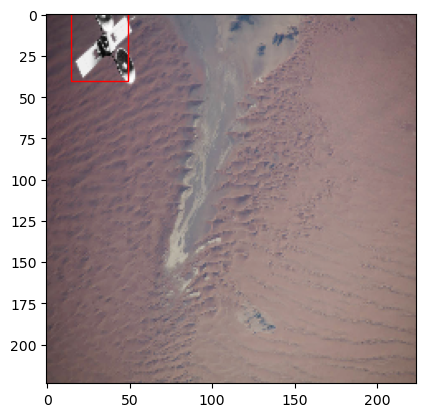

In [ ]:
predicted_bbox = np.squeeze(predicted_bbox)  # Remove batch dimension if present

x_min, y_min, x_max, y_max = predicted_bbox
x_min = x_min*1280/224
x_max = x_max*1280/224
y_min = y_min*1024/224
y_max = y_max*1024/224


# Plotting
fig, ax = plt.subplots(1)
# Display the image
ax.imshow(test_image[0,:,:,:])

# Create a Rectangle patch
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()